In [9]:
import sys
sys.path.append('../../')

In [10]:
from config.constants import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce


In [11]:
plt.style.use('ggplot')

In [12]:
PATH_DATA

'../../data/'

In [13]:
pairs_list = [
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [14]:
df = {}
for pair in range(len(pairs_list)):
    df[pair] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']
                           ['H1'] + '.csv', index_col='Time', parse_dates=True)
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed',
            3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)

In [19]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose',
                   'Low-PrevClose']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis=1)
    return df


def CAGR(df, source_df, account_size):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)


def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)


def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [20]:
# Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['direction'] = np.where(
        df[pair]['Close'] > df[pair]['Open'], 'bull', 'bear')
    df[pair]['dir_count'] = df[pair].groupby(
        (df[pair]['direction'] != df[pair]['direction'].shift(1)).cumsum()).cumcount()+1
    if 'USDJPY/USDJPY_H4 - USDJPY_H4' not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')

    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [21]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    for i in range(50, len(df[pair])):
        # Buy
        if df[pair]['dir_count'][i - 1] >= 5 and df[pair]['direction'][i - 1] == 'bull' and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(
                df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                              'SL': df[pair]['Open'][i]}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

        # Sell
        if df[pair]['dir_count'][i - 1] >= 5 and df[pair]['direction'][i - 1] == 'bear' and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(
                df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                              'SL': df[pair]['Open'][i]}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])

        # Exit trades---------------------------------------------------------------------------
        # Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result': (
                            trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                              'Long profit at price:', round(
                                  df[pair]['Close'][i], 4),
                              'On day:', df[pair].index[i],
                              'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        # Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result': (
                            trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                              'Long loss at price:', round(
                                  df[pair]['Close'][i], 4),
                              'On day:', df[pair].index[i],
                              'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])

        # Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result': (
                            trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                              'Short profit at price:', round(
                                  df[pair]['Close'][i], 4),
                              'On day:', df[pair].index[i],
                              'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        # Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result': (
                            trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                              'Short loss at price:', round(
                                  df[pair]['Close'][i], 4),
                              'On day:', df[pair].index[i],
                              'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        # Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result': (
                        df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j,
                          'Long exited after 12 hours:', round(
                              df[pair]['Close'][i], 4),
                          'On day:', df[pair].index[i],
                          'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result': (
                        trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j,
                          'Short exited after 12 hours:', round(
                              df[pair]['Close'][i], 4),
                          'On day:', df[pair].index[i],
                          'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

60 New Short trade at price: 633.992  On day: 2007-01-03 12:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
60 Short loss at price: 633.992 On day: 2007-01-03 12:00:00 With loss: 31.7 

68 New Short trade at price: 626.777  On day: 2007-01-03 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
68 Short loss at price: 627.512 On day: 2007-01-04 00:00:00 With loss: -50.9 

87 New Long trade at price: 627.528  On day: 2007-01-04 15:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
87 Long loss at price: 627.528 On day: 2007-01-04 15:00:00 With loss: 39.4 

92 New Short trade at price: 621.074  On day: 2007-01-04 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
92 Short loss at price: 621.074 On day: 2007-01-04 20:00:00 With loss: 20.2 

142 New Long trade at price: 609.133  On day: 2007-01-08 22:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
142 Long loss at price: 609.133 On day: 2007-01-08 22:00:00 With loss: 69.8 

148 New Long trade at price: 611.861  On day: 2007-01-09 04:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
148 L

16242 New Long trade at price: 962.986  On day: 2009-08-04 17:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
16242 Long loss at price: 962.986 On day: 2009-08-04 17:00:00 With loss: 487.4 

16307 New Short trade at price: 959.734  On day: 2009-08-07 10:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
16307 Short loss at price: 959.734 On day: 2009-08-07 10:00:00 With loss: 130.2 

16386 New Long trade at price: 948.702  On day: 2009-08-12 17:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
16386 Long loss at price: 948.702 On day: 2009-08-12 17:00:00 With loss: 67.8 

16403 New Long trade at price: 959.698  On day: 2009-08-13 10:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
16403 Long loss at price: 956.678 On day: 2009-08-13 11:00:00 With loss: -256.1 

16434 New Short trade at price: 945.733  On day: 2009-08-14 17:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
16434 Short loss at price: 947.377 On day: 2009-08-14 19:00:00 With loss: -87.6 

16441 New Long trade at price: 944.77  On day: 2009-08-17 00:00:00 Pair: XAU

In [22]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []

    pairs_results[pair] = pd.DataFrame.from_dict(
        {(i, j): trade[pair][j] for j in trade[pair].keys()}, orient='index')
    pairs_results[pair] = pairs_results[pair].drop(
        ['signal', 'ID', 'TP', 'SL'], axis=1)
    pairs_results[pair].set_index('date_of_trade', inplace=True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + \
        account_size

    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']
                             ) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']
                            ) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if - \
            0.1 <= trade[pair][t]['result'] <= 0.1 else ''

my_reduce = partial(pd.merge, on='date_of_trade', how='outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(
    like='result', axis=1).sum(axis=1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + \
    account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

Text(0.5, 1.0, 'Returns of each pair')

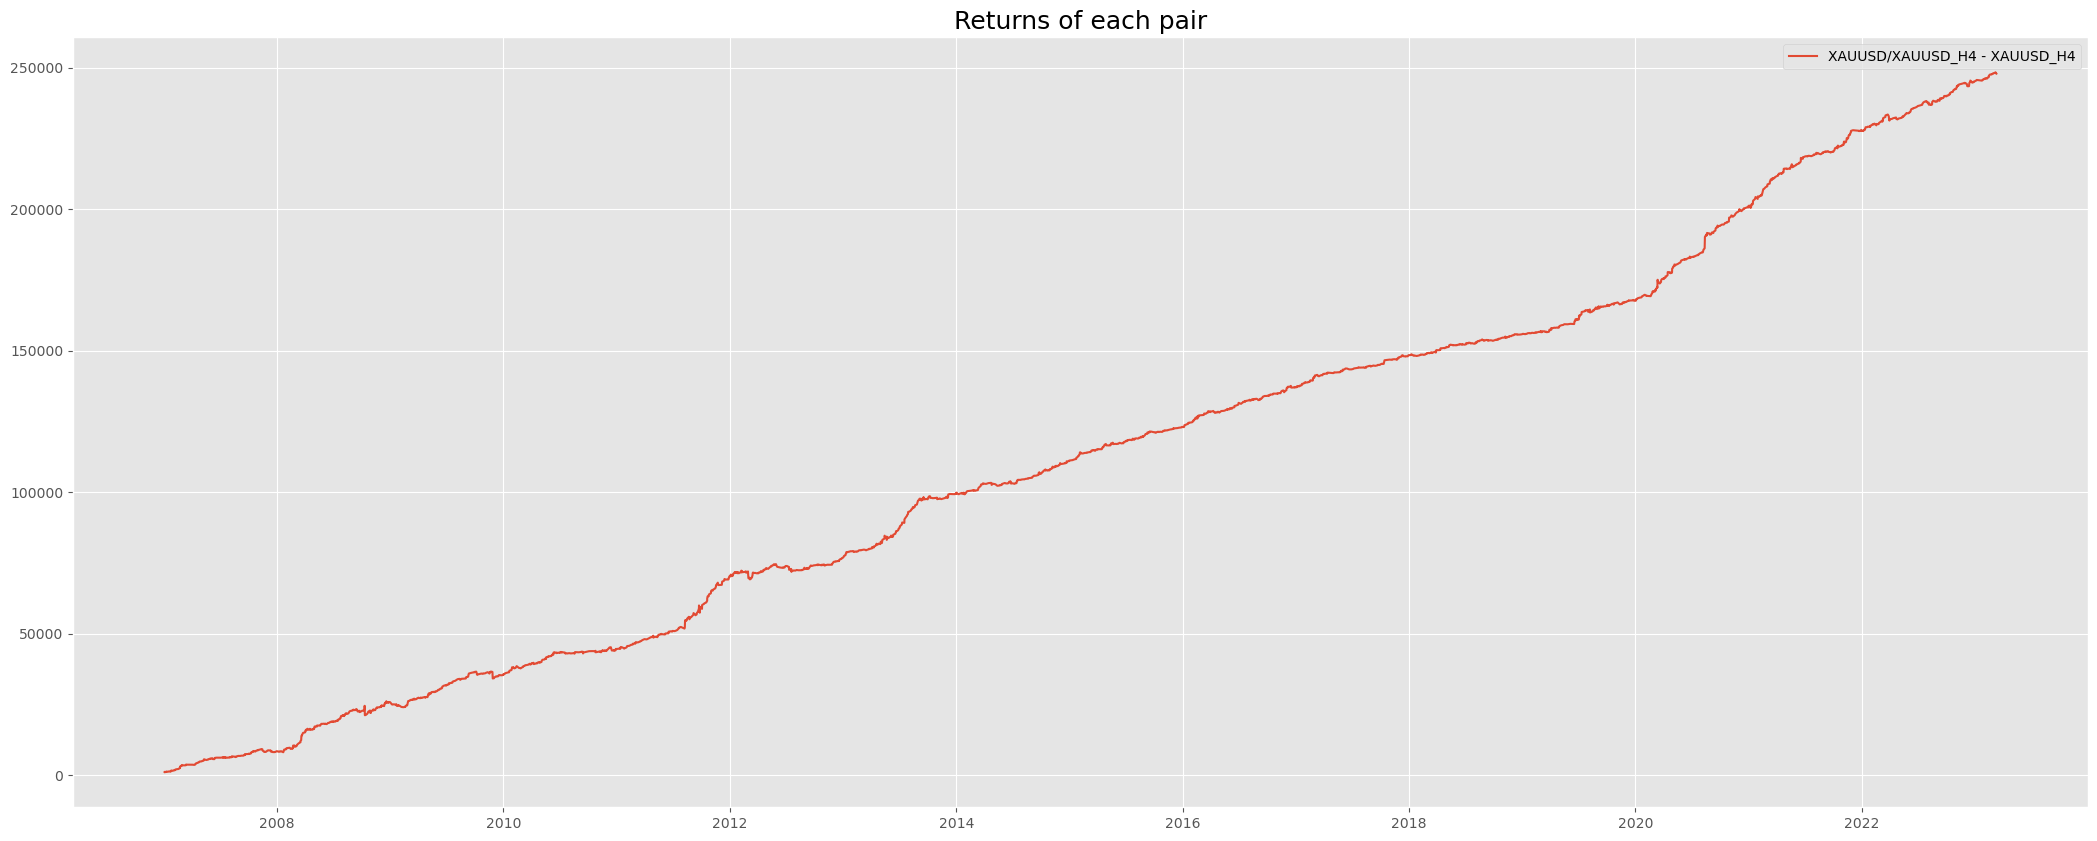

In [23]:
plt.figure(figsize=(26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label=pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize=18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 40.5 %
Sharpe ratio: -0.11
Maximum drawdown 13.65 % 

Number of trades: 2838
Number of profits: 2053
Number of losses: 783
Number of breakevens: 2 

Winning percentage 72.39 %
ROI: 246878
--------------------------------
Average profitable trade: 185.63
Average lossing trade: -171.41
Max profitable trade: 3353.0
Max lossing trade: -3339.4


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

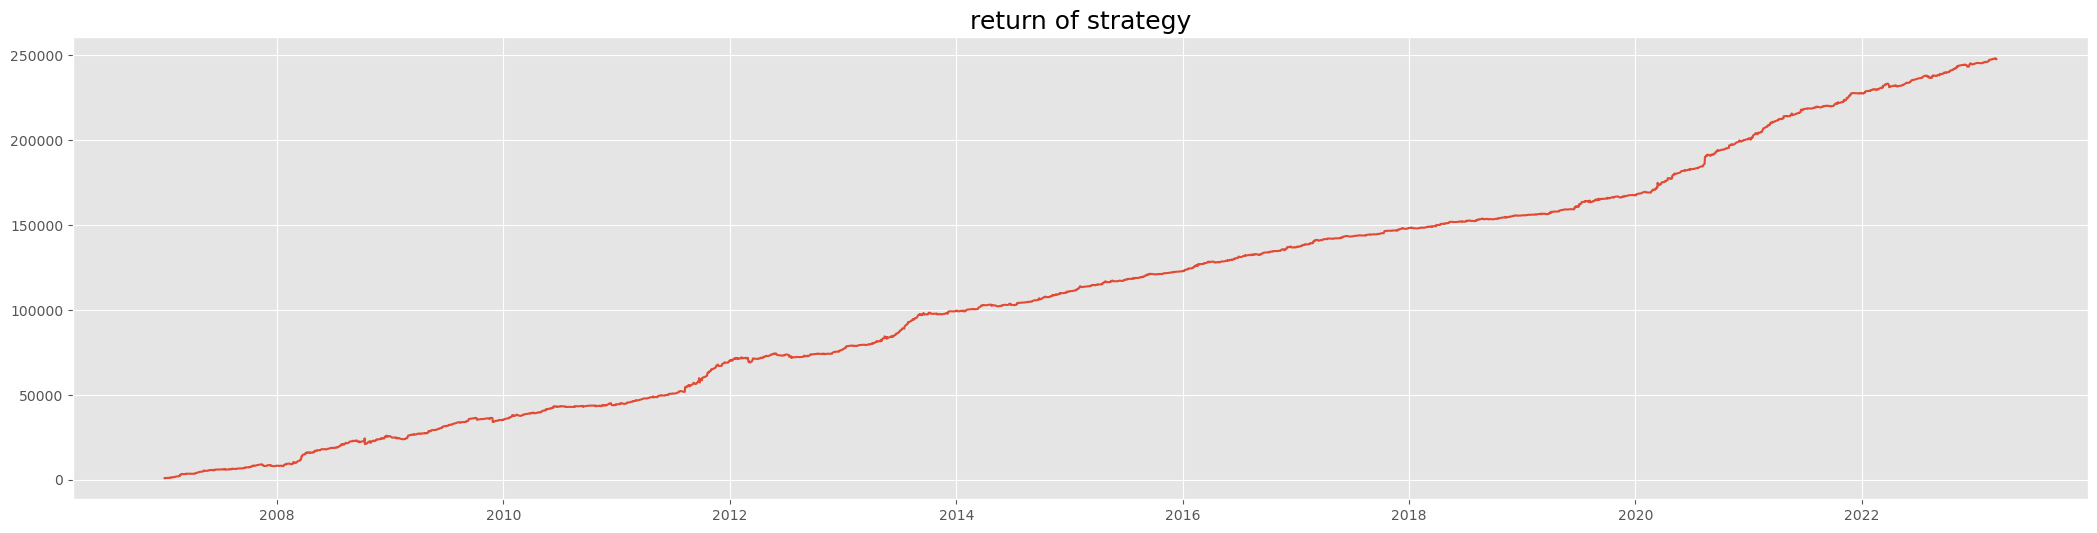

In [24]:
# Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0], account_size), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) /
      (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(
    sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize=(26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize=18)

XAUUSD/XAUUSD_H4 - XAUUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2838
Number of profits: 2053
Number of losses: 783
Number of breakevens: 2 

Winning percentage 72.39 %
ROI: 246877.51
--------------------------------
Average profitable trade: 185.63
Average lossing trade: -171.41
Max profitable trade: 3353.0
Max lossing trade: -3339.4
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    507
Mon    580
Sun     44
Thu    575
Tue    583
Wed    549
Name: result, dtype: int64


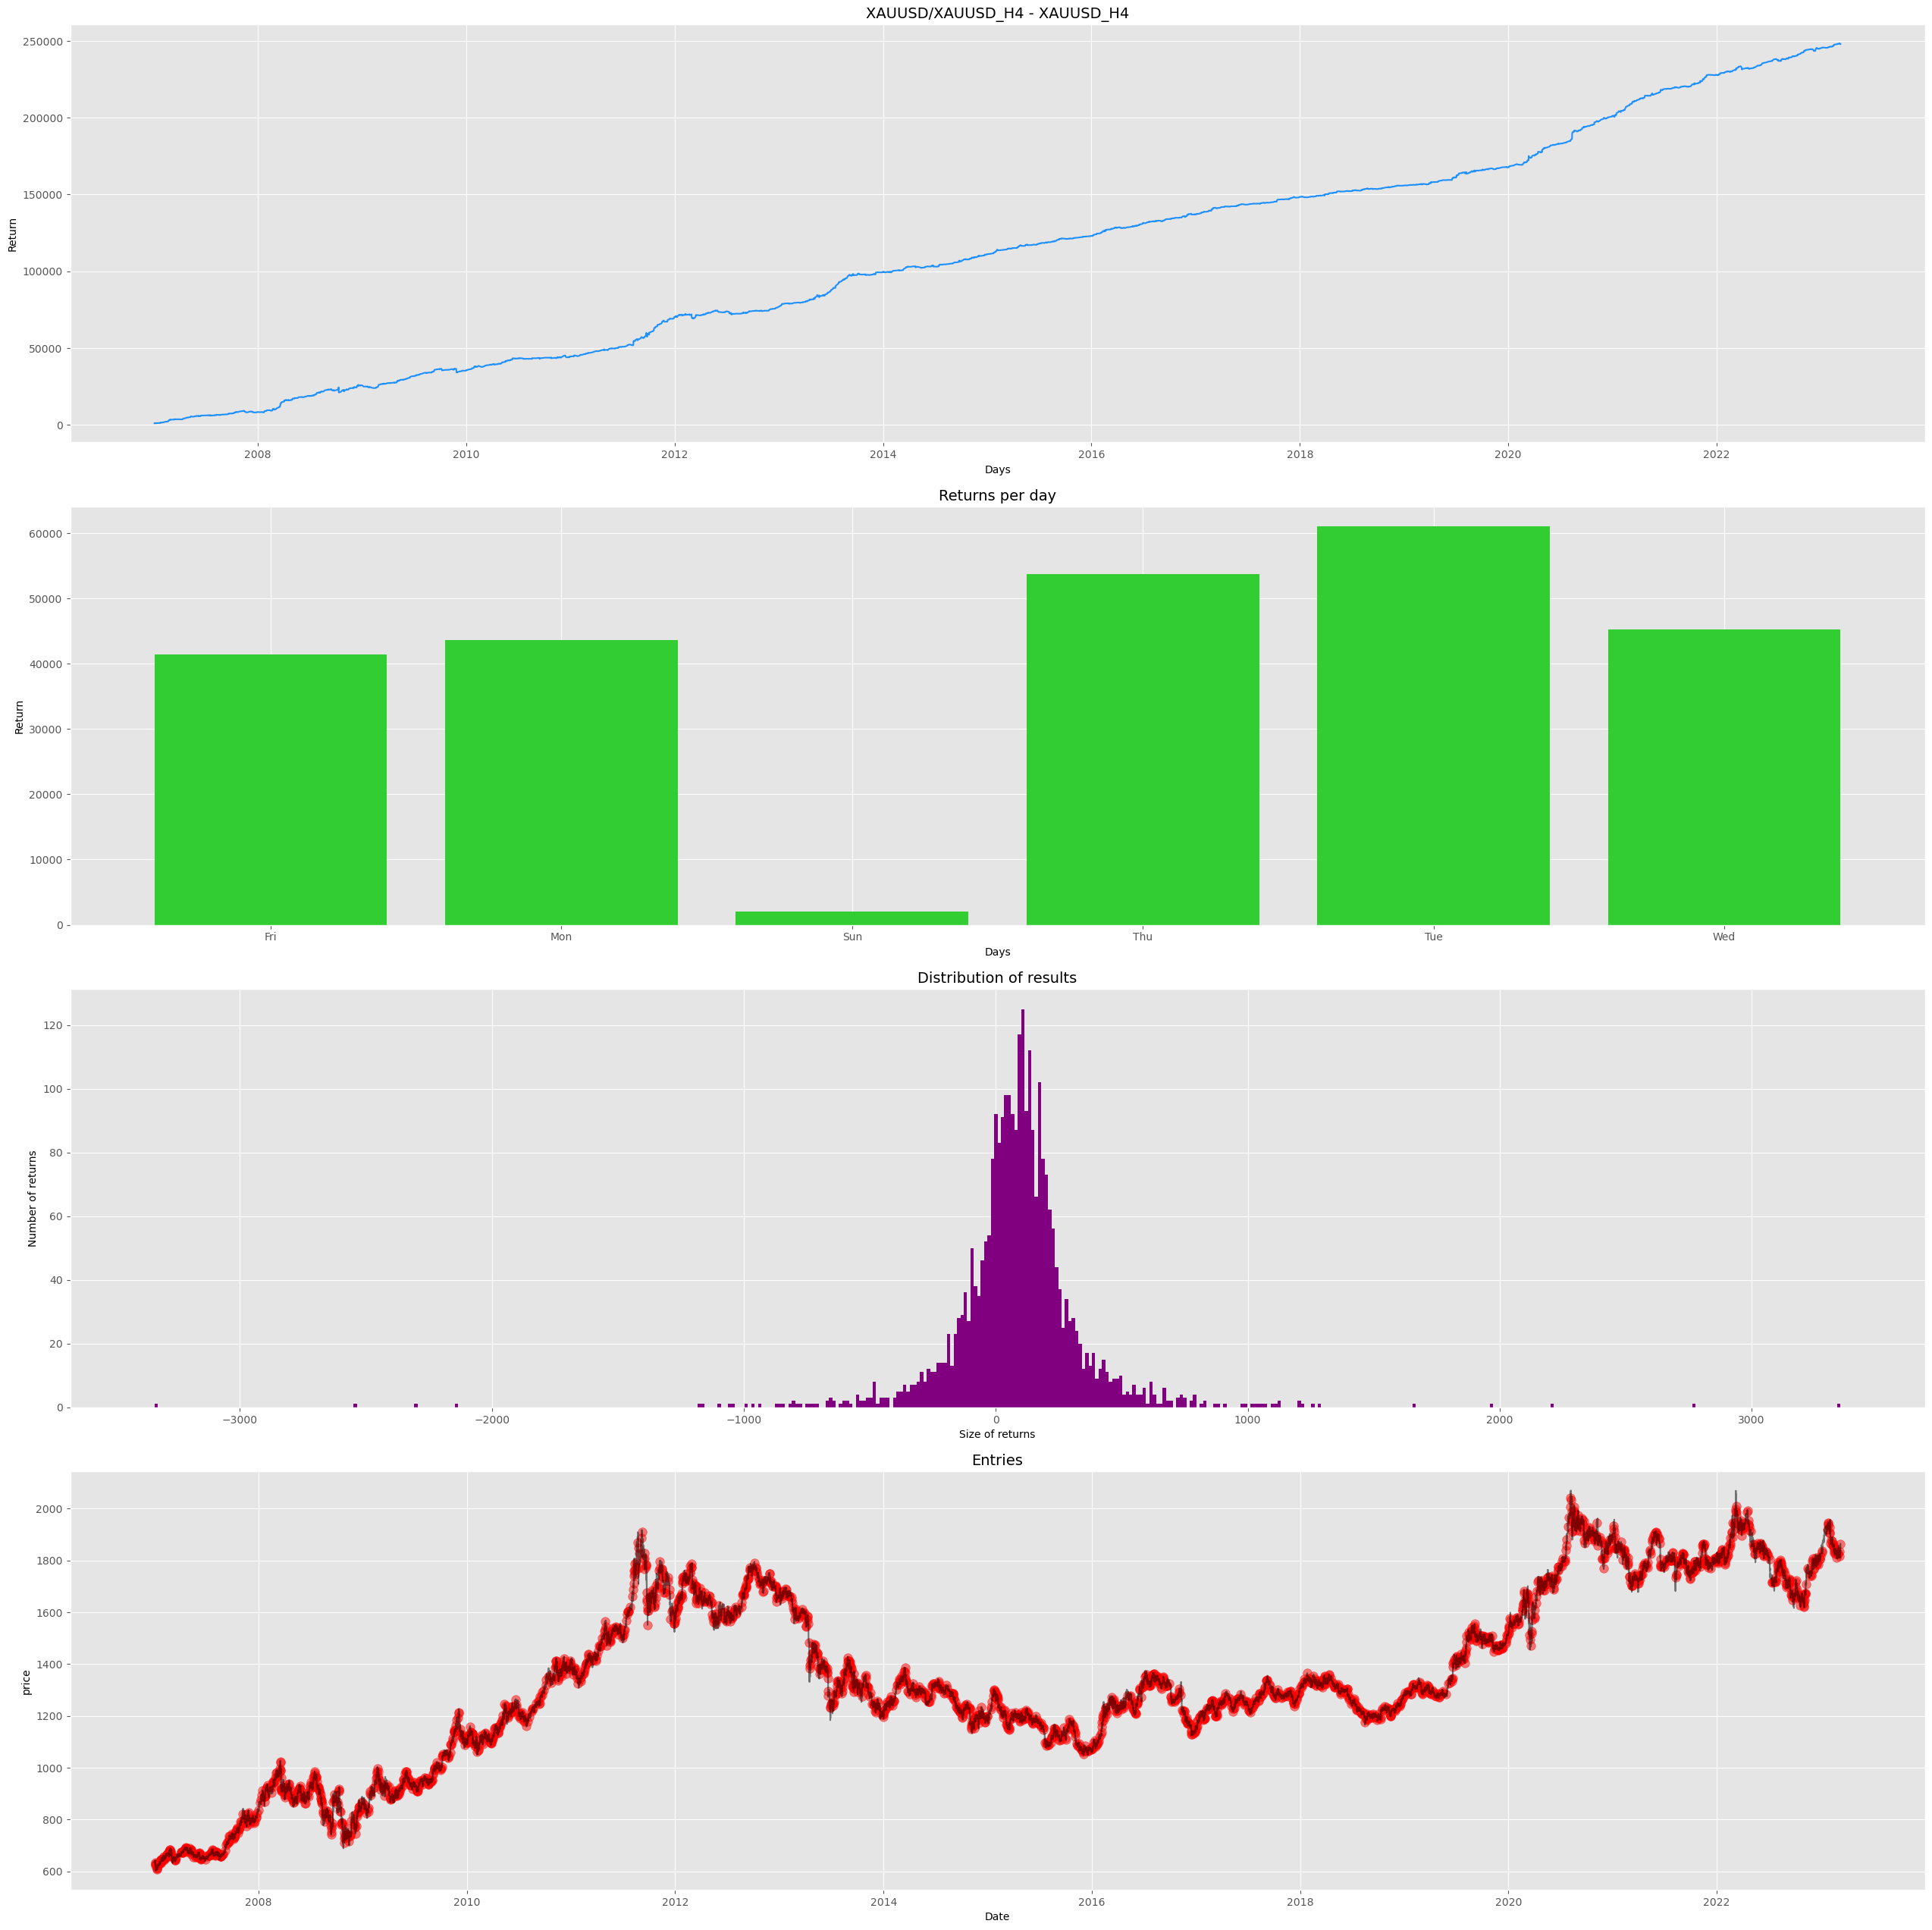

In [25]:
# performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(
        len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(
        sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(
        sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby(
        'day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize=(26, 26))
    fig.tight_layout(pad=4)

    axes[0].plot(pairs_results[pair]['cum_res'], color='dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize=14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height=day_return, color=day_return_positive.map(
        {True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize=14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins=500, color='purple')
    axes[2].set_title('Distribution of results', fontsize=14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color='black', alpha=0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]
                    ['entry_price'], s=70, color='red', alpha=0.5)
    axes[3].set_title('Entries', fontsize=14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()